In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

# Exercise 1

### a

Ix(x,y) = d/dx[g(x) * g(y) * I(x,y)] = d/dx[g(x)] * [g(y) * I(x,y)]

Iy(x,y) = d/dy[g(y) * g(x) * I(x,y)] = d/dy[g(y)] * [g(x) * I(x,y)]

Ixx(x,y) = d/dx[g(x) * g(y) * Ix(x,y)] = d/dx[g(x)] * [g(y) * Ix(x,y)]

Iyy(x,y) = d/dy[g(y) * g(x) * I(x,y)] = d/dy[g(y)] * [g(x) * Iy(x,y)]

Ixy(x,y) = d/dx[g(x) * g(y) * Iy(x,y)] = d/dx[g(x)] * [g(y) * Iy(x,y)]

### b
d/dx[g(x)] = d/dx*1/(sqrt(2*pi)*sigma)*exp(-x^2/(2*sigma^2)) = -1/(sqrt(2*pi)*sigma^3)*x*exp(-x^2/(2*sigma^2))

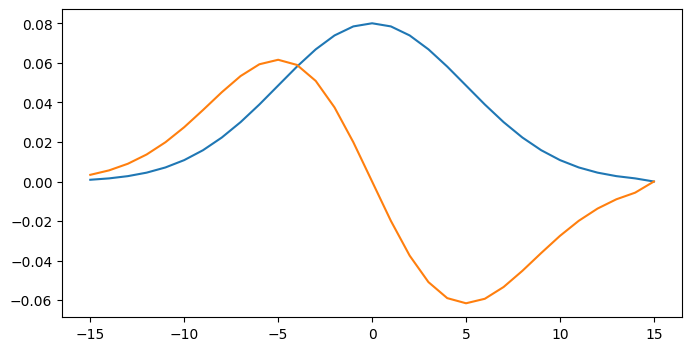

In [3]:
def simple_convolution(signal, kernel):
    N = int(len(kernel) / 2) # kernel of size 2N + 1
    returnSignal = np.zeros(len(signal))
    for i in range(0, len(signal)): # loop through signal
        for j in range(0, 2*N+1): # loop through kenel
            index = i-(j-N)
            if index < 0: # extending edge
                index = 0
            elif index > len(signal)-1:
                index = len(signal)-1
            returnSignal[i] += kernel[j]*signal[index] # weigted sum

    # returnSignal[returnSignal < 0] = 0
    # returnSignal[returnSignal > 255] = 255

    return returnSignal

def filter(img, kernelX, kernelY):
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, kernelX)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, kernelY)
    return img.T    
def filter2(img, kernelX, kernelY):
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, kernelX)        
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, kernelY)
    return img.T

def gauss(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    for x in range(-N, N):
        kernel[x+N] = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x**2 / (2 * (sigma**2)))

    return kernel / np.sum(kernel)

def gaussdx(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    sumOfAbs = 0
    for x in range(-N, N):
        v = -1 / (np.sqrt(2 * np.pi) * sigma**3) * x * np.exp(-x**2 / (2 * (sigma**2)))
        kernel[x+N] = v
        sumOfAbs += np.abs(v)

    return kernel / sumOfAbs


g = gauss(5)
d = gaussdx(5)

# arr = np.zeros(100)
# arr[50] = 10
# arr[51] = 15
# arr[52] = 10
# arrG = simple_convolution(arr, g)
# arrD = simple_convolution(arrG, d)

f = plt.figure(figsize=(8, 4))
f.add_subplot(1, 1, 1)
plt.plot(np.arange(len(g)) - int(len(g) / 2), g)
plt.plot(np.arange(len(d)) - int(len(d) / 2), d)
# plt.plot(np.arange(len(arr)), arr)
# plt.plot(np.arange(len(arrG)), arrG)
# plt.plot(np.arange(len(arrD)), arrD)
plt.show()

### c

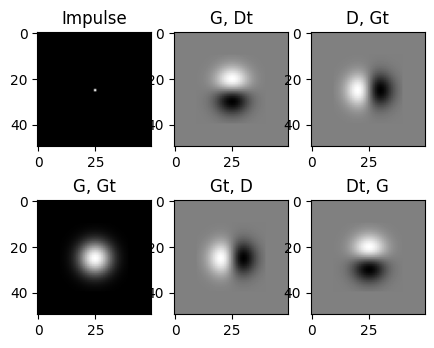

In [4]:
impulse = np.zeros((50, 50))
impulse[25, 25] = 1

ggt = filter(np.copy(impulse), g, g)
gdt = filter(np.copy(impulse), g, d)
dgt = filter(np.copy(impulse), d, g)
gtd = filter2(np.copy(impulse), d, g)
dtg = filter2(np.copy(impulse), g, d)

f = plt.figure(figsize=(5, 4))
f.add_subplot(2, 3, 1)
plt.imshow(impulse, cmap="gray")
plt.title("Impulse")
f.add_subplot(2, 3, 2)
plt.imshow(gdt, cmap="gray")
plt.title("G, Dt")
f.add_subplot(2, 3, 3)
plt.imshow(dgt, cmap="gray")
plt.title("D, Gt")
f.add_subplot(2, 3, 4)
plt.imshow(ggt, cmap="gray")
plt.title("G, Gt")
f.add_subplot(2, 3, 5)
plt.imshow(gtd, cmap="gray")
plt.title("Gt, D")
f.add_subplot(2, 3, 6)
plt.imshow(dtg, cmap="gray")
plt.title("Dt, G")
plt.show()

### d

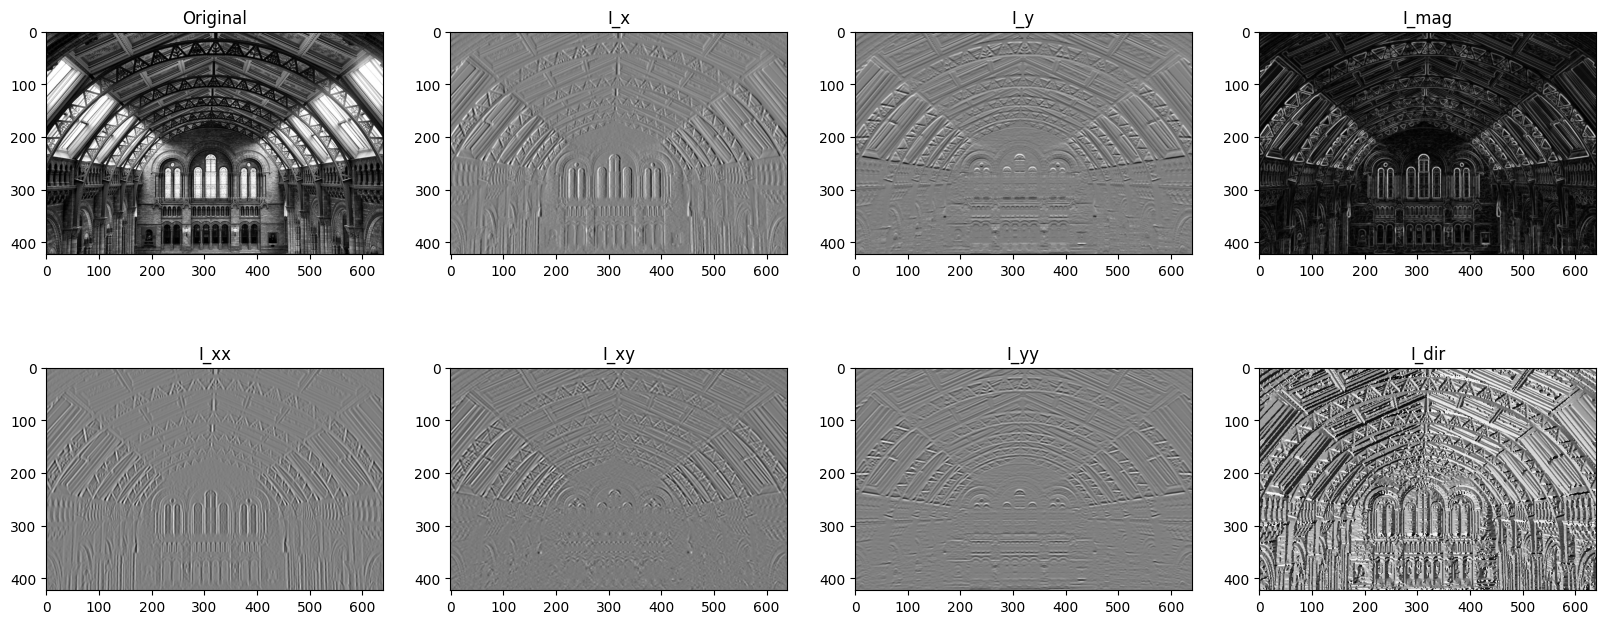

In [5]:
def partialDerivative(img, sigma):
    gaussKenrnel = gauss(sigma)
    dxGaussKernel = gaussdx(sigma)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, dxGaussKernel)
    return img

def getDerivatives(img, sigma):
    Ix = partialDerivative(np.copy(img), sigma)
    Iy = partialDerivative(np.copy(img.T), sigma).T
    Ixx = partialDerivative(np.copy(Ix), sigma)
    Iyy = partialDerivative(np.copy(Iy.T), sigma).T
    Ixy = partialDerivative(np.copy(Ix.T), sigma).T
    return Ix,Iy,Ixx,Iyy,Ixy

def gradient_magnitude(img):
    Ix, Iy, Ixx, Iyy, Ixy = getDerivatives(img, 1)
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    angle = np.arctan2(Iy,Ix)
    return magnitude, angle

temp = cv2.imread('images/museum.jpg') # 0-255
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
temp = temp.astype(np.float64)
g = gauss(1)
d = gaussdx(1)

Ix,Iy,Ixx,Iyy,Ixy = getDerivatives(temp, 1)
# magnitude, angle = gradient_magnitude(temp)
magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
angle = np.arctan2(Ix,Iy)

f = plt.figure(figsize=(20, 8))
f.add_subplot(2, 4, 1)
plt.imshow(temp, cmap="gray")
plt.title("Original")
f.add_subplot(2, 4, 2)
plt.imshow(Ix, cmap="gray")
plt.title("I_x")
f.add_subplot(2, 4, 3)
plt.imshow(Iy, cmap="gray")
plt.title("I_y")
f.add_subplot(2, 4, 4)
plt.imshow(magnitude, cmap="gray")
plt.title("I_mag")
f.add_subplot(2, 4, 5)
plt.imshow(Ixx, cmap="gray")
plt.title("I_xx")
f.add_subplot(2, 4, 6)
plt.imshow(Ixy, cmap="gray")
plt.title("I_xy")
f.add_subplot(2, 4, 7)
plt.imshow(Iyy, cmap="gray")
plt.title("I_yy")
f.add_subplot(2, 4, 8)
plt.imshow(angle, cmap="gray")
plt.title("I_dir")
plt.show()